In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
% cd drive/MyDrive/CJ/

/content/drive/MyDrive/CJ


In [ ]:
from data_eda import data_eda,sum_qty,qty_plot

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [ ]:
data = pd.read_csv('3월.csv')
data2 = pd.read_csv('4월.csv')
data3 = pd.read_csv('5월.csv')
data4 = pd.read_csv('6월.csv')


data = pd.concat((data, data2, data3, data4), axis = 0)
data_org = data

Columns (16,17) have mixed types.Specify dtype option on import or set low_memory=False.
Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.


In [ ]:
data_org.shape

(1786374, 32)

In [ ]:
from sklearn.model_selection import train_test_split
import random

from sklearn.preprocessing import LabelEncoder

columns = ['CORP_ID', 'BKG_DATE', 'SHPR_CD', 'ITEM_SEQ', 'ITEM_CD', 'ITEM_QTY', 'ITEM_AMT','BRAND_NM', 'POST_ZONE']
           # , 'SHPR_ADDR1', 'SHPR_ADDR1', 'CNEE_ADDR1', 'CNEE_ADDR1'
dataset = data_org[columns]

In [ ]:
dataset_gb = dataset.groupby(['ITEM_CD','SHPR_CD','POST_ZONE','BKG_DATE','ITEM_SEQ'],as_index=False).sum()

In [ ]:
dataset_gb.to_csv('whole_dataset.csv')

In [ ]:
dataset_gb

,ITEM_CD,SHPR_CD,POST_ZONE,BKG_DATE,ITEM_SEQ,ITEM_QTY,ITEM_AMT
0,0001,90001341,12.0,20210511,2,1,100.0
1,0001,90001443,12.0,20210511,2,1,100.0
2,0001,90001542,10.0,20210426,2,1,100.0
3,0001,90001542,11.0,20210504,3,1,100.0
4,0001,90001542,24.0,20210426,2,1,100.0
...,...,...,...,...,...,...,...
1310236,whole800002,90001705,63.0,20210621,1,1,137800.0
1310237,whole800002,90001705,63.0,20210622,1,2,275600.0
1310238,whole800002,90001705,63.0,20210627,1,1,137800.0
1310239,whole800002,90001705,63.0,20210628,1,1,137800.0


In [ ]:
from sklearn.preprocessing import MinMaxScaler
category_columns = ['SHPR_CD','ITEM_CD']
for i in category_columns:
  L_encoder = LabelEncoder()
  L_encoder.fit(dataset_gb[i].astype(str))
  dataset_gb[i] = L_encoder.transform(dataset_gb[i].astype(str))

# dataset['year'] = dataset['BKG_DATE'].astype(str).str[0:4].astype(int)
dataset_gb['month'] = dataset_gb['BKG_DATE'].astype(str).str[4:6].astype(int)
dataset_gb['day'] = dataset_gb['BKG_DATE'].astype(str).str[6:].astype(int)

dataset_gb['ITEM_AMT'] = dataset_gb['ITEM_AMT']/dataset_gb['ITEM_QTY']
dataset_gb['ITEM_AMT'] = dataset_gb['ITEM_AMT']/100;
dataset_gb = dataset_gb.drop(columns = 'BKG_DATE')

from sklearn.utils import shuffle

dataset_gb = shuffle(dataset_gb)
Y_total = dataset_gb['ITEM_QTY']

In [ ]:
dataset_gb.shape

(1310241, 8)

In [ ]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import random


X_total = dataset_gb.drop(columns = 'ITEM_QTY')

X_train, X_test, Y_train, Y_test = train_test_split(X_total, Y_total, test_size=0.2, random_state=123)


In [ ]:
import xgboost
!pip install shap
import shap

model = xgboost.XGBRegressor().fit(X_train, Y_train)
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

[02:26:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


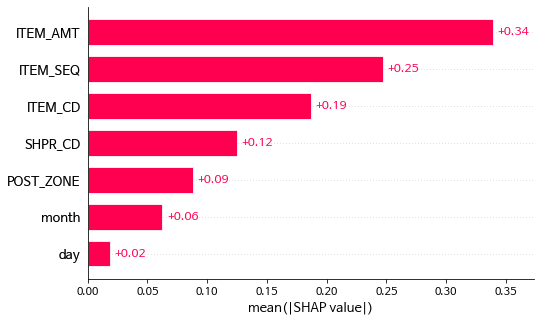

In [ ]:
shap.plots.bar(shap_values)

## Use MF method

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Embedding,Dot,Add,Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD,Adamax
from tensorflow.keras.layers import Dense,Concatenate,Activation

In [ ]:
def RMSE(y_true,y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y_pred,y_true))))

In [ ]:
from keras.callbacks import ModelCheckpoint,EarlyStopping
mc = ModelCheckpoint('best_fianl_model_score_rec.h5',monitor='val_loss',mode='min',save_best_only=True)
es = EarlyStopping(monitor='val_loss',patience=3)

In [ ]:
I = dataset_gb.ITEM_CD.max()+1
S = dataset_gb.SHPR_CD.max()+1
P = int(dataset_gb.POST_ZONE.max())+1
IS = dataset_gb.ITEM_SEQ.max()+1
IA = int(dataset_gb.ITEM_AMT.max())+1
M = dataset_gb.month.max()+1
D = dataset_gb.day.max()+1

In [ ]:
IA

11710

In [ ]:
itemcd = Input(shape=(1,))
shpr = Input(shape=(1,))
post = Input(shape=(1,))
itemseq = Input(shape=(1,))
itemamt = Input(shape=(1,))
month = Input(shape=(1,))
day = Input(shape=(1,))

K = 150

I_embedding = Embedding(I,K,embeddings_regularizer=l2())(itemcd)
S_embedding = Embedding(S,K,embeddings_regularizer=l2())(shpr)
P_embedding = Embedding(P,K,embeddings_regularizer=l2())(post)
IS_embedding = Embedding(IS,K,embeddings_regularizer=l2())(itemseq)
IA_embedding = Embedding(IA,K,embeddings_regularizer=l2())(itemamt) 
M_embedding = Embedding(M,K,embeddings_regularizer=l2())(month)
D_embedding = Embedding(D,K,embeddings_regularizer=l2())(day)



#아래 부분은 경향성 부분인데, 아직 안보이니 pass

IA_bias = Embedding(IA,1,embeddings_regularizer=l2())(itemamt)
IS_bias = Embedding(IS,1,embeddings_regularizer=l2())(itemseq)

#user_bias = Embedding(U.max()+1,1,embeddings_regularizer=l2())(user) #user를 특정 할 수 있는 정보가 있을 때 사용
#sex_bias = Embedding(S,1,embeddings_regularizer=l2())(sex)
#age_bias = Embedding(A,1,embeddings_regularizer=l2())(age)
#hj_bias = Embedding(H,1,embeddings_regularizer=l2())(hj)
#item_bias = Embedding(I,1,embeddings_regularizer=l2())(item_buz)

from tensorflow.keras.layers import Dense,Concatenate,Activation

I_embedding = Flatten()(I_embedding)
S_embedding = Flatten()(S_embedding)
P_embedding = Flatten()(P_embedding)
IS_embedding = Flatten()(IS_embedding)
IA_embedding = Flatten()(IA_embedding)
M_embedding = Flatten()(M_embedding)
D_embedding = Flatten()(D_embedding)

IA_bias = Flatten()(IA_bias)
IS_bias = Flatten()(IS_bias)
#user_bias = Flatten()(user_bias)
#sex_bias = Flatten()(sex_bias)
#age_bias = Flatten()(age_bias)
#hj_bias = Flatten()(hj_bias)
#item_bias = Flatten()(item_bias)


#user_bias 와 U_embedding을 user를 특정 할 수 있는 정보가 있다면 추가하면 좋다. => 더 높은 정확성과, 적은 오류를 가질 것이다.
R = Concatenate()([I_embedding,S_embedding,P_embedding,IS_embedding,IA_embedding,M_embedding,D_embedding,IA_bias,IS_bias])

R = Dense(2048)(R)
R = Activation('relu')(R)
R = Dense(256)(R)
R = Activation('relu')(R)
R = Dense(1)(R) #소비 점수를 output으로 가져온다(정확한 평가 지표가 있었다면, 조금 더 좋았을 것)

model = Model(inputs=[itemcd,shpr,post,itemseq,itemamt,month,day],outputs=R)
model.compile(
    loss = RMSE,
    optimizer = 'Adam',
    metrics = [RMSE]
)

model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_57 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_58 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_59 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_60 (InputLayer)           [(None, 1)]          0                                            
____________________________________________________________________________________________

In [ ]:
display(X_train.columns)
display(Y_train.values)

Index(['ITEM_CD', 'SHPR_CD', 'POST_ZONE', 'ITEM_SEQ', 'ITEM_AMT', 'month',
       'day'],
      dtype='object')

array([1, 1, 1, ..., 1, 2, 1])

In [ ]:
Y_test.values

array([1, 2, 1, ..., 3, 1, 1])

In [ ]:
result = Y_train.values
result_test = Y_test.values

In [ ]:
from keras.callbacks import ModelCheckpoint,EarlyStopping
mc = ModelCheckpoint('best_fianl_model_score_rec.h5',monitor='val_loss',mode='min',save_best_only=True)
es = EarlyStopping(monitor='val_loss',patience=3)

In [ ]:
import numpy as np

X_train, X_test, Y_train, Y_test = train_test_split(X_total, Y_total, test_size=0.2, random_state=123)
#Model(inputs=[itemcd,shpr,post,itemseq,month,day],outputs=R) => model input seq
result = model.fit(
    x=[X_train.ITEM_CD,X_train.SHPR_CD,X_train.POST_ZONE,X_train.ITEM_SEQ,X_train.ITEM_AMT,X_train.month,X_train.day],
    y=np.float32(result),
    epochs = 10,
    batch_size=64,
    validation_data=(
        [X_test.ITEM_CD,X_test.SHPR_CD,X_test.POST_ZONE,X_test.ITEM_SEQ,X_test.ITEM_AMT,X_test.month,X_test.day],
        np.float32(result_test),
    ),
)

Epoch 1/10
16378/16378 [==============================] - 512s 31ms/step - loss: 2.1280 - RMSE: 1.9582 - val_loss: 2.0811 - val_RMSE: 1.9387
Epoch 2/10
16378/16378 [==============================] - 511s 31ms/step - loss: 2.0296 - RMSE: 1.8740 - val_loss: 2.0350 - val_RMSE: 1.8777
Epoch 3/10
16378/16378 [==============================] - 511s 31ms/step - loss: 1.9986 - RMSE: 1.8297 - val_loss: 2.0133 - val_RMSE: 1.8488
Epoch 4/10
16378/16378 [==============================] - 511s 31ms/step - loss: 1.9855 - RMSE: 1.8054 - val_loss: 2.0578 - val_RMSE: 1.8634
Epoch 5/10
16378/16378 [==============================] - 510s 31ms/step - loss: 1.9713 - RMSE: 1.7879 - val_loss: 1.9947 - val_RMSE: 1.8134
Epoch 6/10
16378/16378 [==============================] - 508s 31ms/step - loss: 1.9623 - RMSE: 1.7768 - val_loss: 1.9731 - val_RMSE: 1.7914
Epoch 7/10
16378/16378 [==============================] - 507s 31ms/step - loss: 1.9540 - RMSE: 1.7666 - val_loss: 1.9735 - val_RMSE: 1.7787
Epoch 8/10
16